In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h.pth
!pip install monai

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7atw75mp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7atw75mp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2025-02-21 17:49:22--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.68, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h.pth’

sam_vit_h.pth       100%[===================>]   2.3

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import cv2
from transformers import SamProcessor
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset as TorchDataset
from segment_anything import sam_model_registry
import torchvision.transforms as T
import numpy as np
from torchvision.transforms import functional as TF
from tqdm import tqdm
from PIL import Image


In [3]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Import SamProcessor from transformers.
# Make sure you have installed the latest version of transformers.
try:
    from transformers import SamProcessor
except ImportError as e:
    raise ImportError("SamProcessor could not be imported. Ensure you have installed the transformers package: pip install transformers") from e

def get_bounding_box(ground_truth_map):
    """
    Compute the bounding box for nonzero values in the ground truth mask.
    The ground_truth_map is assumed to be a 2D numpy array.
    Returns [x_min, y_min, x_max, y_max] or None if the mask is empty.
    """
    if ground_truth_map.ndim > 2:
        ground_truth_map = np.squeeze(ground_truth_map)
    coords = np.column_stack(np.where(ground_truth_map > 0))
    if coords.size == 0:
        return None
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return [int(x_min), int(y_min), int(x_max), int(y_max)]

def preprocess_for_unet(image_tensor):
    """
    Resize the image tensor for the U-Net branch.
    """
    return T.Resize((256, 256))(image_tensor)

class CombinedDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load original images and masks as PIL images.
        orig_image = Image.open(self.image_paths[idx]).convert("RGB")
        orig_mask  = Image.open(self.mask_paths[idx]).convert("L")
        
        # Apply augmentation if provided.
        if self.transform:
            image_tensor, mask_tensor = self.transform(orig_image, orig_mask)
        else:
            image_tensor = TF.to_tensor(orig_image)
            mask_tensor = TF.to_tensor(orig_mask)
        
        # For the SAM branch, use the original PIL image.
        gt_mask_np = np.array(orig_mask)
        bbox = get_bounding_box(gt_mask_np)
        if bbox is None:
            bbox = [0, 0, 0, 0]
        
        # Generate SAM inputs. Assumes the processor accepts a PIL image and input_boxes.
        inputs = self.processor(orig_image, input_boxes=[[bbox]], return_tensors="pt")
        sam_inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        sam_inputs["ground_truth_mask"] = torch.tensor(gt_mask_np, dtype=torch.int64)
        
        # For the U-Net branch, resize the augmented image.
        unet_inputs = preprocess_for_unet(image_tensor)
        
        return sam_inputs, unet_inputs, mask_tensor

class SegmentationAugmentation:
    def __init__(self, resize=(1024, 1024), mask_size=(64, 64), augmentation=True, angle_range=(-10, 10)):
        self.resize = resize
        self.mask_size = mask_size
        self.augmentation = augmentation
        self.angle_range = angle_range if augmentation else (0, 0)

    def __call__(self, image, mask):
        if self.augmentation:
            if random.random() < 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            angle = random.uniform(*self.angle_range)
            image = TF.rotate(image, angle, interpolation=T.InterpolationMode.BILINEAR, fill=0)
            mask = TF.rotate(mask, angle, interpolation=T.InterpolationMode.NEAREST, fill=0)
        image = TF.resize(image, self.resize, interpolation=T.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, self.mask_size, interpolation=T.InterpolationMode.NEAREST)
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

# Define dataset paths.
image_dir = "/kaggle/input/ham1000-segmentation-and-classification/images"
mask_dir  = "/kaggle/input/ham1000-segmentation-and-classification/masks"
valid_image_extensions = ('.jpg', '.jpeg', '.png')
image_paths = sorted([p for p in glob(os.path.join(image_dir, "*.*"))
                       if p.lower().endswith(valid_image_extensions)])
mask_paths = sorted([p for p in glob(os.path.join(mask_dir, "*.*"))
                     if p.lower().endswith('.png')])

print("Total images found:", len(image_paths))
print("Total masks found:", len(mask_paths))

# Optionally sample a subset.
sample_size = 1000
if len(image_paths) >= sample_size:
    random.seed(42)
    sample_indices = random.sample(range(len(image_paths)), sample_size)
    image_paths = [image_paths[i] for i in sample_indices]
    mask_paths  = [mask_paths[i] for i in sample_indices]
else:
    print("Not enough images available. Using all images.")

# Split into training and validation sets.
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
print("Train dataset size:", len(train_imgs))
print("Validation dataset size:", len(val_imgs))

# Create augmentations and processor.
train_transform = SegmentationAugmentation(resize=(1024, 1024), mask_size=(64, 64), augmentation=True)
val_transform   = SegmentationAugmentation(resize=(1024, 1024), mask_size=(64, 64), augmentation=False)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create datasets and data loaders.
train_dataset = CombinedDataset(train_imgs, train_masks, processor, transform=train_transform)
val_dataset   = CombinedDataset(val_imgs, val_masks, processor, transform=val_transform)
# ===============================================================================================================

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


Total images found: 10015
Total masks found: 10015
Train dataset size: 800
Validation dataset size: 200


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import monai

# =============================================================================
# Patch Embedding Module
# =============================================================================
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int = 256, patch_size: int = 32, in_channels: int = 3, embed_dim: int = 1280):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> (torch.Tensor, int, int):
        x = self.proj(x)
        B, C, H, W = x.size()
        x = x.flatten(2).transpose(1, 2)
        return x, H, W

# =============================================================================
# Hyper-Attention Module
# =============================================================================
class HyperAttention(nn.Module):
    def __init__(self, in_channels: int, num_heads: int = 8, dropout: float = 0.1):
        super(HyperAttention, self).__init__()
        self.in_channels = in_channels
        self.norm = nn.LayerNorm(in_channels)
        self.attn = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels * 4),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels * 4, in_channels)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        x_flat = x.flatten(2).permute(2, 0, 1)
        x_norm = self.norm(x_flat)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        x_att = x_flat + self.dropout(attn_output)
        x_mlp = self.mlp(x_att)
        x_out = x_att + self.dropout(x_mlp)
        x_out = x_out.permute(1, 2, 0).reshape(B, C, H, W)
        return x_out

# =============================================================================
# Upsampling Block for Decoder
# =============================================================================
class UpBlock(nn.Module):
    def __init__(self, in_channels: int, skip_channels: int, out_channels: int, bilinear: bool = True, dropout_rate: float = 0.1):
        super(UpBlock, self).__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
            
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
    
    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = self.up(x)
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

# =============================================================================
# Fusion Block to Combine Encoder Features
# =============================================================================
class FusionBlock(nn.Module):
    def __init__(self, in_channels_res: int, in_channels_sam: int, out_channels: int, dropout_rate: float = 0.1):
        super(FusionBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels_res + in_channels_sam, out_channels, kernel_size=4, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x_res: torch.Tensor, x_sam: torch.Tensor) -> torch.Tensor:
        if x_sam.shape[2:] != x_res.shape[2:]:
            x_sam = F.interpolate(x_sam, size=x_res.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x_res, x_sam], dim=1)
        return self.conv(x)

# =============================================================================
# Combined Model: ResNet101 + SAM + Hyper-Attention + U-Net Decoder
# =============================================================================
class SAM_U_Net_Model(nn.Module):
    def __init__(
        self,
        out_channels: int,
        sam_model_registry: dict,
        checkpoint_path: str,
        use_patch_embed: bool = True,
        bilinear: bool = True,
        pretrained: bool = True,
        dropout_rate: float = 0.1
    ):
        super(SAM_U_Net_Model, self).__init__()
        self.use_patch_embed = use_patch_embed
        self.bilinear = bilinear
        
        # ResNet-101 Encoder
        resnet = models.resnet101(pretrained=pretrained)
        self.input_conv = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.maxpool    = resnet.maxpool
        self.encoder1   = resnet.layer1
        self.encoder2   = resnet.layer2
        self.encoder3   = resnet.layer3
        self.encoder4   = resnet.layer4
        
        # SAM Encoder
        sam = sam_model_registry["vit_h"](checkpoint="/kaggle/working/sam_vit_h.pth")
        sam_encoder_full = sam.image_encoder
        for param in sam_encoder_full.parameters():
            param.requires_grad = False
        if self.use_patch_embed:
            # (You may want to update in_channels here if needed.)
            self.sam_patch_embed = nn.Conv2d(in_channels=3, out_channels=1280, kernel_size=16, stride=16)
            self.patch_dropout = nn.Dropout(dropout_rate)
            # Instead of a Sequential, store the first 6 SAM blocks in a ModuleList.
            self.sam_blocks = nn.ModuleList(list(sam_encoder_full.blocks)[:6])
            # Fusion layer: will combine outputs from two groups (each with 1280 channels) → 1280 channels.
            self.sam_fusion = nn.Conv2d(1280 * 2, 1280, kernel_size=1)
        else:
            self.sam_encoder = nn.Sequential(*list(sam_encoder_full.blocks)[:6])
        
        # Fusion block to combine ResNet and SAM features
        self.fusion = nn.Sequential(
            nn.Conv2d(2048 + 1280, 2048, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
        
        # Hyper-Attention
        self.hyper_attention = nn.Sequential(
            nn.LayerNorm(2048),
            nn.MultiheadAttention(embed_dim=2048, num_heads=8, dropout=dropout_rate)
        )
        
        # Decoder
        self.up1 = UpBlock(2048, 1024, 1024, bilinear, dropout_rate)
        self.up2 = UpBlock(1024, 512, 512, bilinear, dropout_rate)
        self.up3 = UpBlock(512, 256, 256, bilinear, dropout_rate)
        self.up4 = UpBlock(256, 64, 64, bilinear, dropout_rate)
        # Modified output layer for binary segmentation
        self.out_conv = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
        )
    
    def forward(self, sam_input: torch.Tensor, unet_input: torch.Tensor) -> torch.Tensor:
        # U-Net branch (ResNet-based)
        x0 = self.input_conv(unet_input)
        x1 = self.maxpool(x0)
        x1 = self.encoder1(x1)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        
        # SAM branch with skip connections between SAM blocks:
        if self.use_patch_embed:
            x_sam = self.sam_patch_embed(sam_input)
            x_sam = self.patch_dropout(x_sam)
            B, C, H_sam, W_sam = x_sam.shape
            # Permute to (B, H, W, C) as expected by the SAM blocks
            x_sam = x_sam.permute(0, 2, 3, 1)
            outputs = []
            for block in self.sam_blocks:
                x_sam = block(x_sam)
                outputs.append(x_sam)
            # Fuse group A: blocks 1,3,5 (indices 0,2,4)
            groupA = outputs[0] + outputs[2] + outputs[4]
            # Fuse group B: blocks 2,4,6 (indices 1,3,5)
            groupB = outputs[1] + outputs[3] + outputs[5]
            # Concatenate along the channel dimension (last dimension)
            fused = torch.cat([groupA, groupB], dim=-1)  # shape: (B, H, W, 2560)
            # Permute back to (B, C, H, W)
            fused = fused.permute(0, 3, 1, 2)
            # Fuse the concatenated features to get back to 1280 channels.
            x_sam = self.sam_fusion(fused)
        else:
            x_sam = self.sam_encoder(sam_input)
        
        # Fusion: combine ResNet and SAM features
        if x_sam.shape[2:] != x4.shape[2:]:
            x_sam = F.interpolate(x_sam, size=x4.shape[2:], mode='bilinear', align_corners=True)
        x_fused = torch.cat([x4, x_sam], dim=1)
        x_fused = self.fusion(x_fused)
        
        # Hyper-Attention
        B, C, H, W = x_fused.shape
        x_flat = x_fused.flatten(2).transpose(1, 2)
        normed = self.hyper_attention[0](x_flat)
        attn_output, _ = self.hyper_attention[1](normed.transpose(0, 1), 
                                                  normed.transpose(0, 1), 
                                                  normed.transpose(0, 1))
        x_flat = x_flat + attn_output.transpose(0, 1)
        x_fused = x_flat.transpose(1, 2).reshape(B, C, H, W)
        
        # Decoder
        d1 = self.up1(x_fused, x3)
        d2 = self.up2(d1, x2)
        d3 = self.up3(d2, x1)
        d4 = self.up4(d3, x0)
        d5 = F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=True)
        out = self.out_conv(d5)  # Outputs probabilities in [0,1]
        return out

print("Model structure ready for binary segmentation.")


Model structure ready for binary segmentation.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai

# ------------------------------------------------------------------------------
# Helper Functions for Losses and Metrics (Binary Segmentation Version)
# ------------------------------------------------------------------------------

bce_loss_fn = torch.nn.BCEWithLogitsLoss()

def prepare_target(target: torch.Tensor) -> torch.Tensor:
    """
    Squeeze the singleton channel dimension from target if present.
    """
    if target.dim() == 4 and target.shape[1] == 1:
        return target.squeeze(1)
    return target

def get_preds(outputs: torch.Tensor, threshold: float = 0.5) -> torch.Tensor:
    """
    Convert raw logits to predicted segmentation masks for binary segmentation.
    Applies sigmoid, thresholds the predictions, and removes the channel dimension.
    """
    if outputs.dim() != 4 or outputs.shape[1] != 1:
        raise ValueError("Expected outputs to be a 4D tensor with 1 channel for binary segmentation.")
    return (torch.sigmoid(outputs) > threshold).long().squeeze(1)

def prepare_bce_targets(targets: torch.Tensor, num_classes: int) -> torch.Tensor:
    """
    Prepare targets for BCE loss.
    For binary segmentation (num_classes == 1), ensure targets have a singleton channel.
    """
    if num_classes == 1:
        targets = prepare_target(targets)
        # Add channel dimension if missing so that shape becomes [B, 1, H, W]
        return targets.unsqueeze(1).float() if targets.dim() == 3 else targets.float()
    else:
        one_hot = monai.networks.utils.one_hot(targets, num_classes).float()
        return one_hot

def iou_loss(inputs: torch.Tensor, targets: torch.Tensor, smooth: float = 1e-6) -> torch.Tensor:
    """
    Compute negative log IoU loss.
    
    For binary segmentation:
      - Uses sigmoid to get probabilities from a single-channel output.
      - Assumes targets are in [B, 1, H, W] (or [B, H, W] which will be unsqueezed).
    """
    if inputs.shape[1] == 1:
        # Binary segmentation: use sigmoid
        inputs = torch.sigmoid(inputs)
        if targets.dim() == 3:
            targets = targets.unsqueeze(1)
    else:
        # Fallback for multi-class (not expected here)
        inputs = torch.softmax(inputs, dim=1)
    intersection = (inputs * targets).sum(dim=(2, 3))
    union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    loss = -torch.log(iou + smooth)
    return loss.mean()

def combined_loss(outputs: torch.Tensor, targets: torch.Tensor, w_iou: float = 0.5, w_bce: float = 0.5) -> torch.Tensor:
    """
    Combined loss as a weighted sum of IoU loss and BCEWithLogitsLoss for binary segmentation.
    
    Assumes outputs of shape [B, 1, H, W] and targets as [B, H, W] or [B, 1, H, W].
    """
    # For binary segmentation, there is one output channel.
    if outputs.shape[1] != 1:
        raise ValueError("This combined_loss function is designed for binary segmentation (1 channel).")
    
    # Ensure targets for IoU loss are [B, 1, H, W]
    targets_iou = targets if targets.dim() == 4 else targets.unsqueeze(1)
    if targets_iou.shape[2:] != outputs.shape[2:]:
        targets_iou = F.interpolate(targets_iou.float(), size=outputs.shape[2:], mode='nearest')
    loss_iou_val = iou_loss(outputs, targets_iou)
    
    # Prepare targets for BCE loss (also [B, 1, H, W])
    targets_bce = prepare_bce_targets(targets, 1)
    if targets_bce.shape[2:] != outputs.shape[2:]:
        targets_bce = F.interpolate(targets_bce, size=outputs.shape[2:], mode='nearest')
    loss_bce_val = bce_loss_fn(outputs, targets_bce)
    
    return w_iou * loss_iou_val + w_bce * loss_bce_val

criterion = combined_loss

def compute_dice(outputs: torch.Tensor, targets: torch.Tensor, smooth: float = 1e-6) -> torch.Tensor:
    """
    Compute the Dice coefficient for binary segmentation.
    """
    outputs = outputs.float()
    preds = (torch.sigmoid(outputs) > 0.5).long().squeeze(1)
    targets = prepare_target(targets)
    # One-hot encoding with 2 classes: background and foreground.
    preds_one_hot = F.one_hot(preds, num_classes=2).permute(0, 3, 1, 2).float()
    targets_one_hot = F.one_hot(targets.long(), num_classes=2).permute(0, 3, 1, 2).float()
    if targets_one_hot.shape[2:] != outputs.shape[2:]:
        targets_one_hot = F.interpolate(targets_one_hot, size=outputs.shape[2:], mode='nearest')
    intersection = (preds_one_hot * targets_one_hot).sum(dim=(2, 3))
    summation = preds_one_hot.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (summation + smooth)
    return dice.mean()

def pixel_accuracy(outputs: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5) -> float:
    """
    Compute the pixel-wise accuracy for binary segmentation.
    """
    preds = get_preds(outputs, threshold)  # [B, H, W]
    targets = prepare_target(targets).long()  # [B, H, W]
    
    # Upsample target mask if spatial dimensions don't match.
    if preds.shape[1:] != targets.shape[1:]:
        targets = targets.unsqueeze(1).float()
        targets = F.interpolate(targets, size=preds.shape[1:], mode='nearest')
        targets = targets.squeeze(1).long()
    
    batch_size = targets.size(0)
    correct = (preds == targets).float().view(batch_size, -1).sum(dim=1)
    total = targets[0].numel()
    return (correct / total).mean().item()

def compute_iou(outputs: torch.Tensor, targets: torch.Tensor, smooth: float = 1e-6) -> float:
    """
    Compute the Intersection over Union (IoU) metric for binary segmentation.
    """
    outputs = outputs.float()
    preds = (torch.sigmoid(outputs) > 0.5).long().squeeze(1)
    targets = prepare_target(targets).long()
    # One-hot encode to have 2 classes: background and foreground.
    preds_one_hot = F.one_hot(preds, num_classes=2).permute(0, 3, 1, 2).float()
    targets_one_hot = F.one_hot(targets, num_classes=2).permute(0, 3, 1, 2).float()
    if targets_one_hot.shape[2:] != outputs.shape[2:]:
        targets_one_hot = F.interpolate(targets_one_hot, size=outputs.shape[2:], mode='nearest')
    intersection = (preds_one_hot * targets_one_hot).sum(dim=(2, 3))
    union = preds_one_hot.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()


In [6]:
import warnings
warnings.filterwarnings("ignore", message="The following named arguments are not valid for")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.cuda.amp as amp

# ------------------------------
# Training Setup & Loop
# ------------------------------
# Select primary GPU (GPU:0) as default device.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the model.
model = SAM_U_Net_Model(
    out_channels=1,  # single-channel output for binary segmentation
    sam_model_registry=sam_model_registry,
    checkpoint_path="sam_vit_h.pth",
    use_patch_embed=True,
    bilinear=True,
    pretrained=True
)

# If more than one GPU is available, wrap the model for data parallelism.
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training.")
    model = nn.DataParallel(model)

model = model.to(device, memory_format=torch.channels_last)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Warmup scheduler: linearly increase learning rate for the first few epochs.
warmup_epochs = 5
warmup_factor = 0.1
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda epoch: warmup_factor + (1 - warmup_factor) * min(1.0, epoch / warmup_epochs)
)

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
num_epochs = 100
accumulation_steps = 4

# Early stopping parameters.
patience = 10  # Number of epochs to wait for improvement before stopping.
best_val_loss = float('inf')
early_stop_counter = 0

# Lists to record epoch-level metrics.
train_loss_history = []
train_acc_history = []
train_dice_history = []
train_iou_history = []

val_loss_history = []
val_acc_history = []
val_dice_history = []
val_iou_history = []

for epoch in range(num_epochs):
    model.train()  # Model returns raw logits now.
    train_metrics = {'loss': 0.0, 'acc': 0.0, 'dice': 0.0, 'iou': 0.0}
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    optimizer.zero_grad()
    scaler = amp.GradScaler()
    for i, (sam_inputs, unet_inputs, masks) in enumerate(train_loop):
        # Move inputs and targets to the device.
        sam_tensor = sam_inputs["pixel_values"].to(device, memory_format=torch.channels_last)
        unet_inputs = unet_inputs.to(device, memory_format=torch.channels_last)
        masks = masks.to(device, memory_format=torch.channels_last).long()  # expected shape: [B, H, W]
        
        with torch.amp.autocast(device_type='cuda'):
            # Model returns raw logits [B, 1, H, W] in training mode.
            outputs = model(sam_tensor, unet_inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Compute loss. (Criterion expects raw logits.)
            loss = criterion(outputs, masks) / accumulation_steps
        
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        batch_size = masks.size(0)
        train_metrics['loss'] += loss.item() * batch_size * accumulation_steps
        train_metrics['acc']  += pixel_accuracy(outputs, masks) * batch_size
        train_metrics['dice'] += compute_dice(outputs, masks) * batch_size
        train_metrics['iou']  += compute_iou(outputs, masks) * batch_size
        
        processed = (i + 1) * batch_size
        train_loop.set_postfix({
            'loss': f"{train_metrics['loss'] / processed:.4f}",
            'acc': f"{train_metrics['acc'] / processed:.4f}",
            'dice': f"{train_metrics['dice'] / processed:.4f}",
            'iou': f"{train_metrics['iou'] / processed:.4f}"
        })
    
    train_loss = train_metrics['loss'] / len(train_dataset)
    train_acc  = train_metrics['acc']  / len(train_dataset)
    train_dice = train_metrics['dice'] / len(train_dataset)
    train_iou  = train_metrics['iou']  / len(train_dataset)
    
    # Record training metrics.
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    train_dice_history.append(train_dice)
    train_iou_history.append(train_iou)
    
    model.eval()  # In evaluation mode, the model returns a binary mask.
    val_metrics = {'loss': 0.0, 'acc': 0.0, 'dice': 0.0, 'iou': 0.0}
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
    with torch.no_grad():
        for sam_inputs, unet_inputs, masks in val_loop:
            sam_tensor = sam_inputs["pixel_values"].to(device, memory_format=torch.channels_last)
            unet_inputs = unet_inputs.to(device, memory_format=torch.channels_last)
            masks = masks.to(device, memory_format=torch.channels_last).long()
            
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(sam_tensor, unet_inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                loss = criterion(outputs, masks)
            
            batch_size = masks.size(0)
            val_metrics['loss'] += loss.item() * batch_size
            val_metrics['acc']  += pixel_accuracy(outputs, masks) * batch_size
            val_metrics['dice'] += compute_dice(outputs, masks) * batch_size
            val_metrics['iou']  += compute_iou(outputs, masks) * batch_size
            
            processed = (val_loop.n + 1) * batch_size
            avg_loss = val_metrics['loss'] / processed
            avg_acc  = val_metrics['acc'] / processed
            avg_dice = val_metrics['dice'] / processed
            avg_iou  = val_metrics['iou'] / processed
            val_loop.set_postfix({
                'loss': f"{avg_loss:.4f}",
                'acc': f"{avg_acc:.4f}",
                'dice': f"{avg_dice:.4f}",
                'iou': f"{avg_iou:.4f}"
            })
    
    val_loss = val_metrics['loss'] / len(val_dataset)
    val_acc  = val_metrics['acc']  / len(val_dataset)
    val_dice = val_metrics['dice'] / len(val_dataset)
    val_iou  = val_metrics['iou']  / len(val_dataset)
    
    # Record validation metrics.
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    val_dice_history.append(val_dice)
    val_iou_history.append(val_iou)
    
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")
    
    # Check for early stopping.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Save the best model checkpoint.
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "SEG_best_model.pth"))
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    torch.cuda.empty_cache()



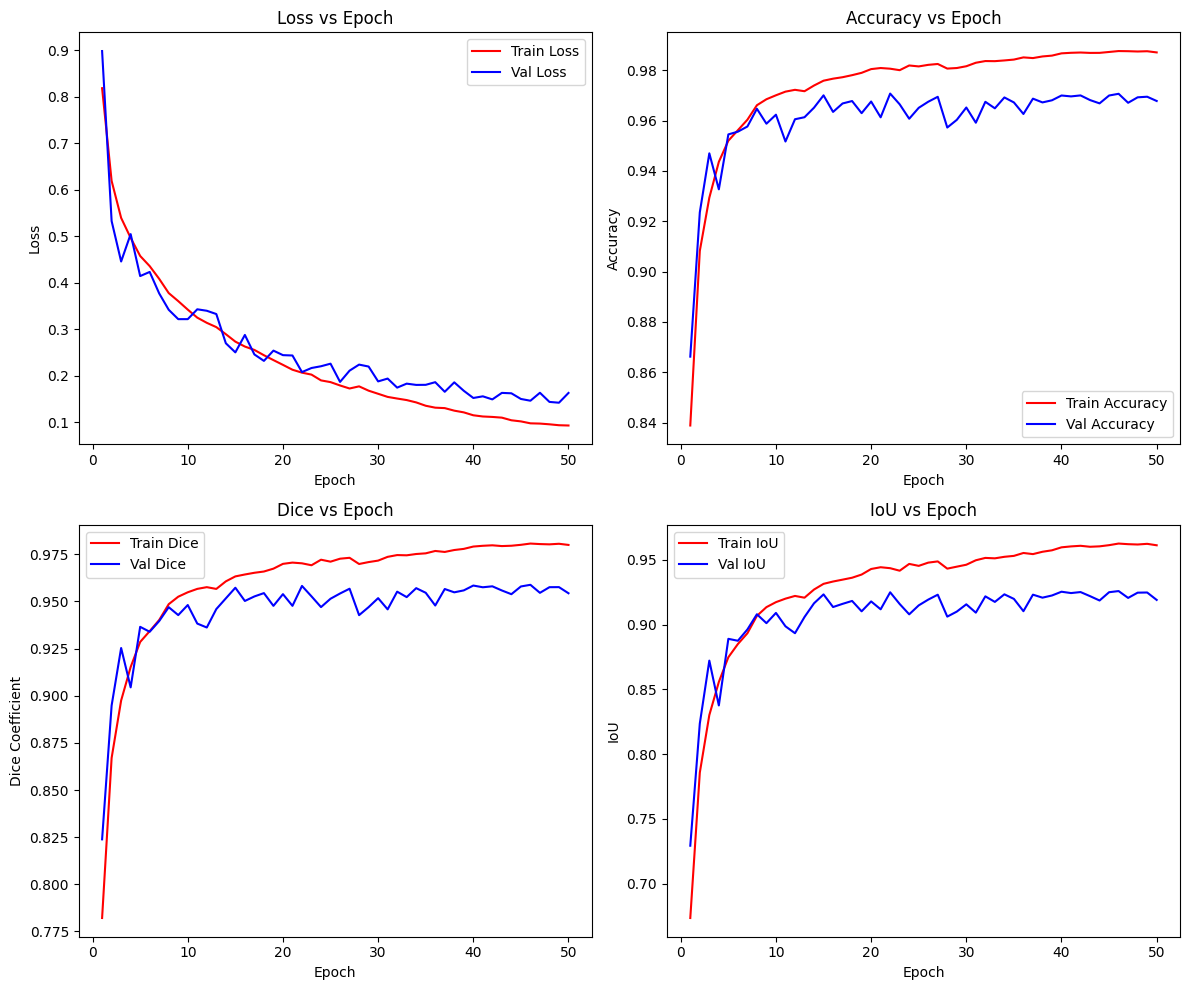

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Convert metric lists to Python scalars if they are tensors.
train_loss_history = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss_history]
val_loss_history = [x.cpu().item() if torch.is_tensor(x) else x for x in val_loss_history]
train_acc_history = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc_history]
val_acc_history = [x.cpu().item() if torch.is_tensor(x) else x for x in val_acc_history]
train_dice_history = [x.cpu().item() if torch.is_tensor(x) else x for x in train_dice_history]
val_dice_history = [x.cpu().item() if torch.is_tensor(x) else x for x in val_dice_history]
train_iou_history = [x.cpu().item() if torch.is_tensor(x) else x for x in train_iou_history]
val_iou_history = [x.cpu().item() if torch.is_tensor(x) else x for x in val_iou_history]

epochs = range(1, len(train_loss_history) + 1)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(list(epochs), train_loss_history, 'r-', label='Train Loss')
plt.plot(list(epochs), val_loss_history, 'b-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(list(epochs), train_acc_history, 'r-', label='Train Accuracy')
plt.plot(list(epochs), val_acc_history, 'b-', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(list(epochs), train_dice_history, 'r-', label='Train Dice')
plt.plot(list(epochs), val_dice_history, 'b-', label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice vs Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(list(epochs), train_iou_history, 'r-', label='Train IoU')
plt.plot(list(epochs), val_iou_history, 'b-', label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


ISIC-2016 dataset length: 379
ISIC-2018 dataset length: 800
HAM 10000 dataset length: 800


<ipython-input-23-602a3ca37d58>:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_checkpoint))



--- Testing on ISIC-2016 dataset (Visualization) ---


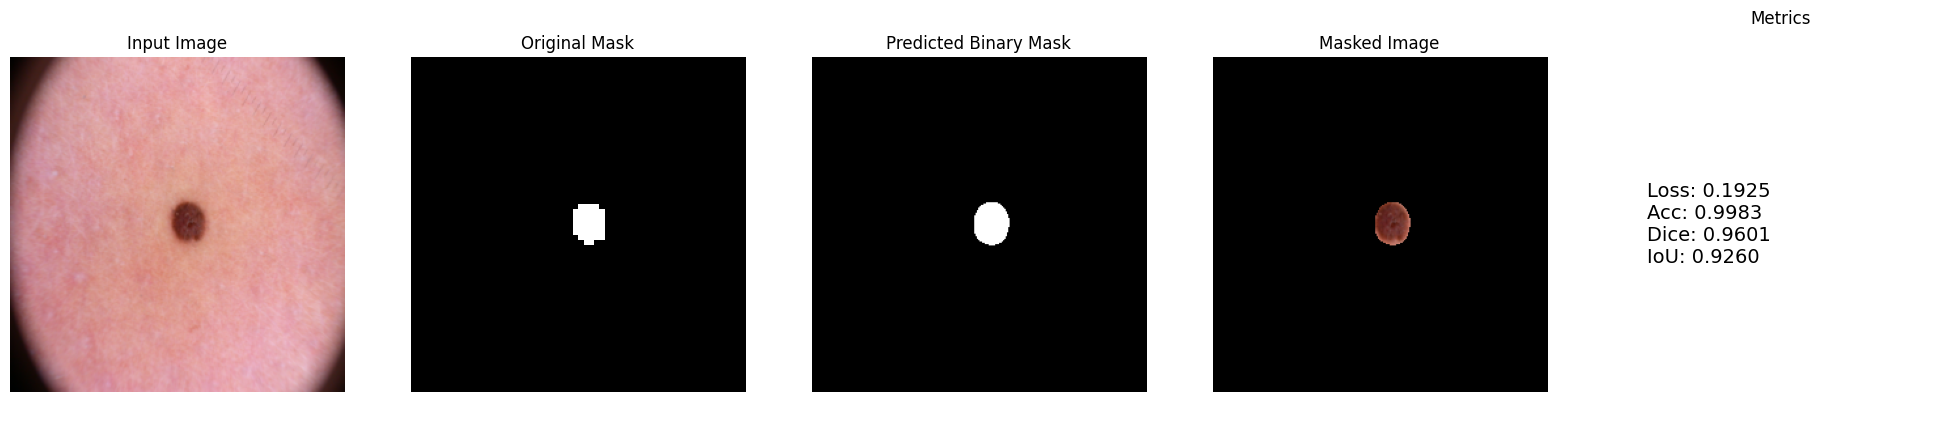

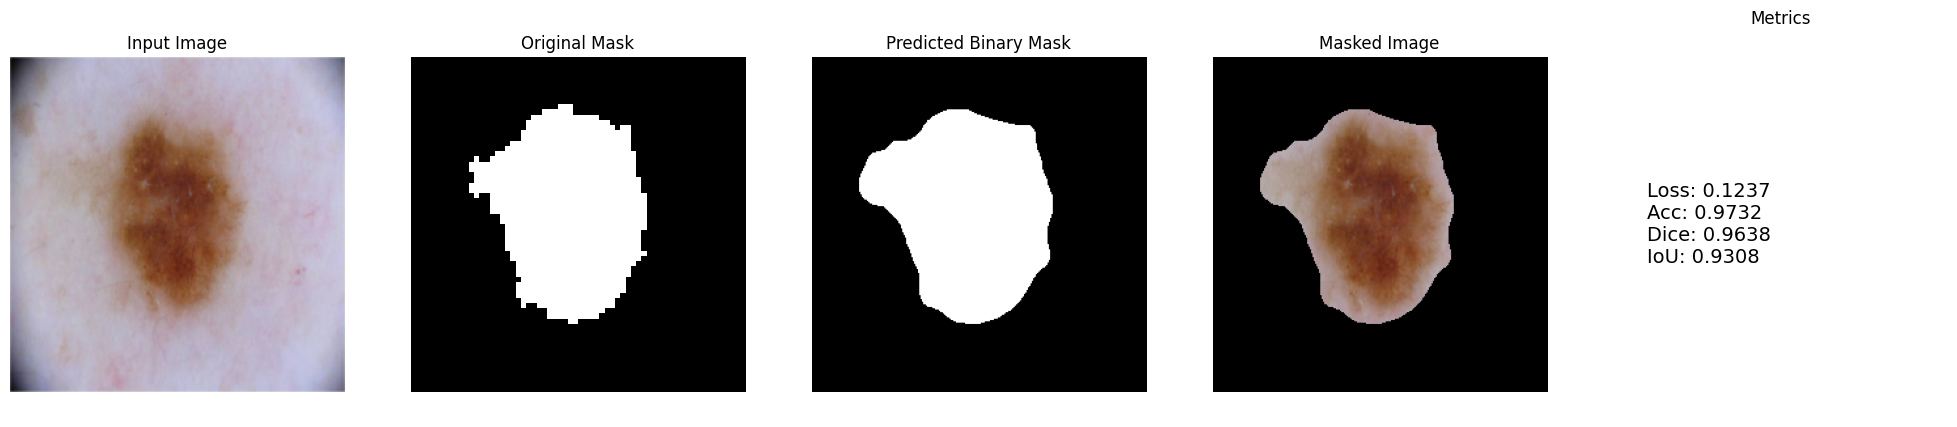

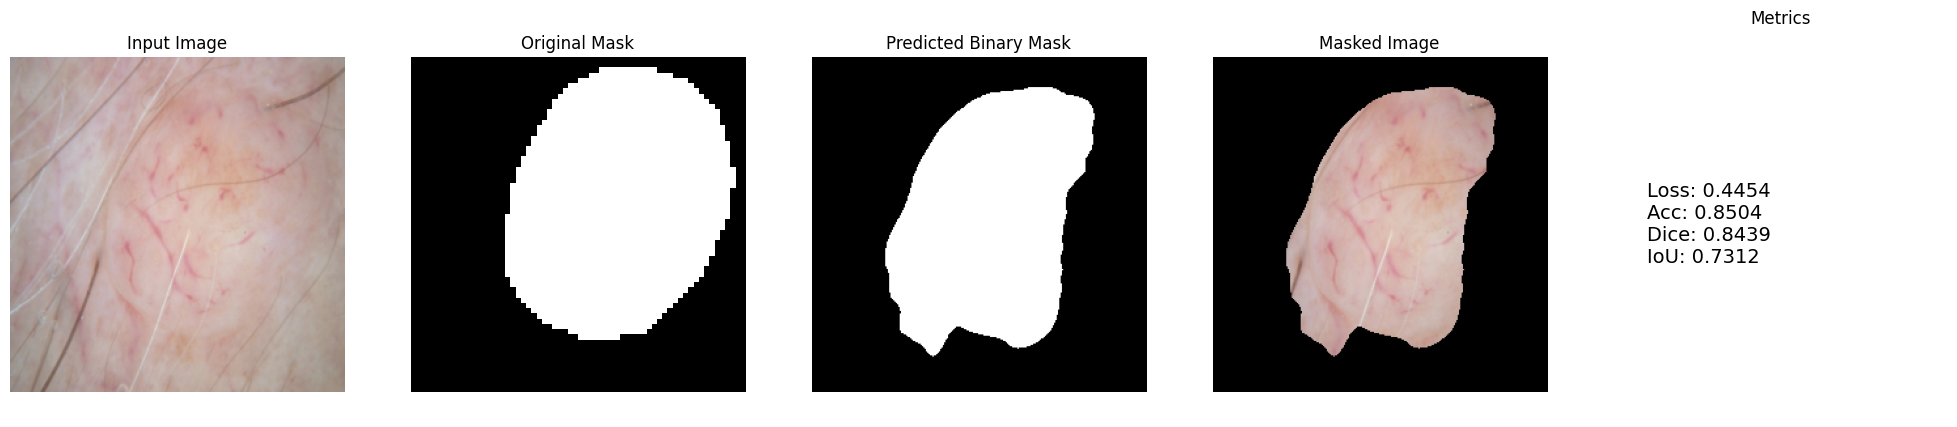


--- Testing on ISIC-2018 dataset (Visualization) ---


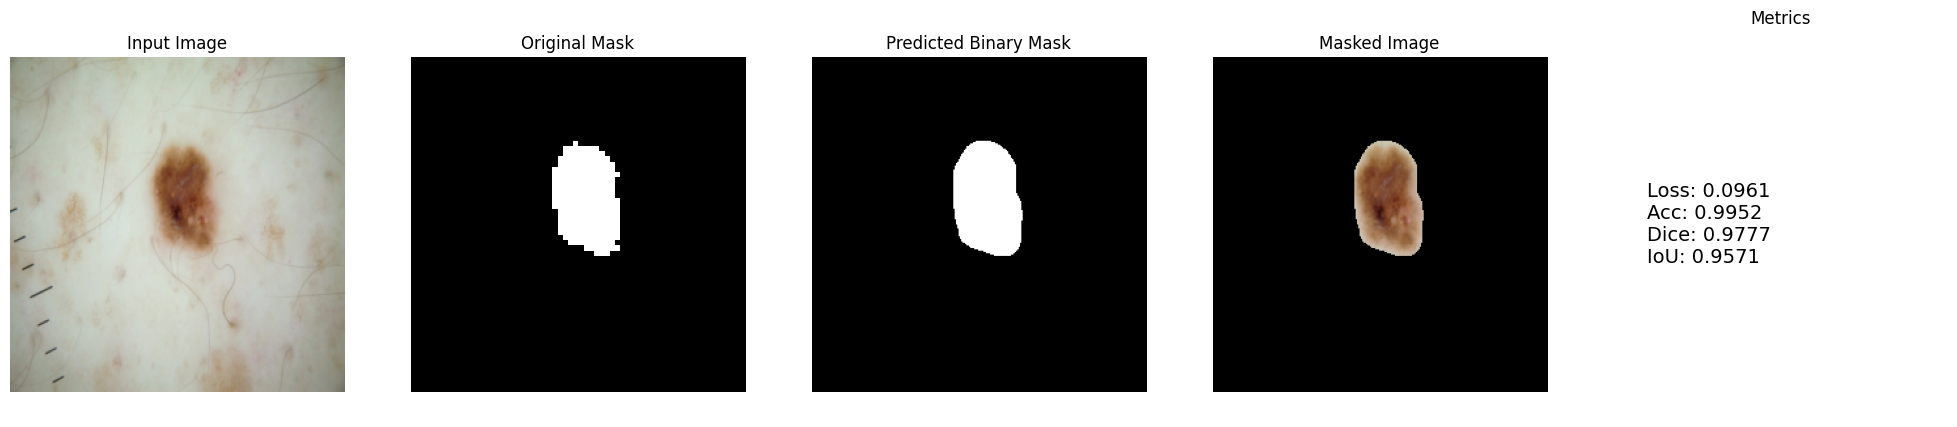

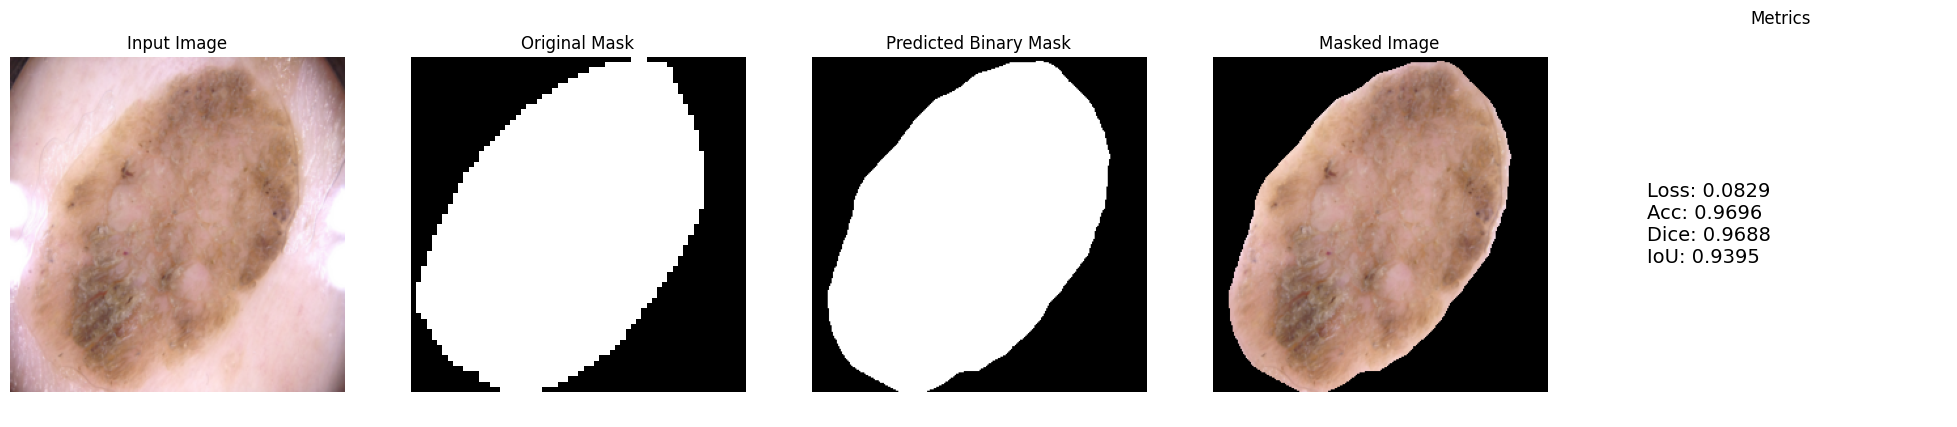

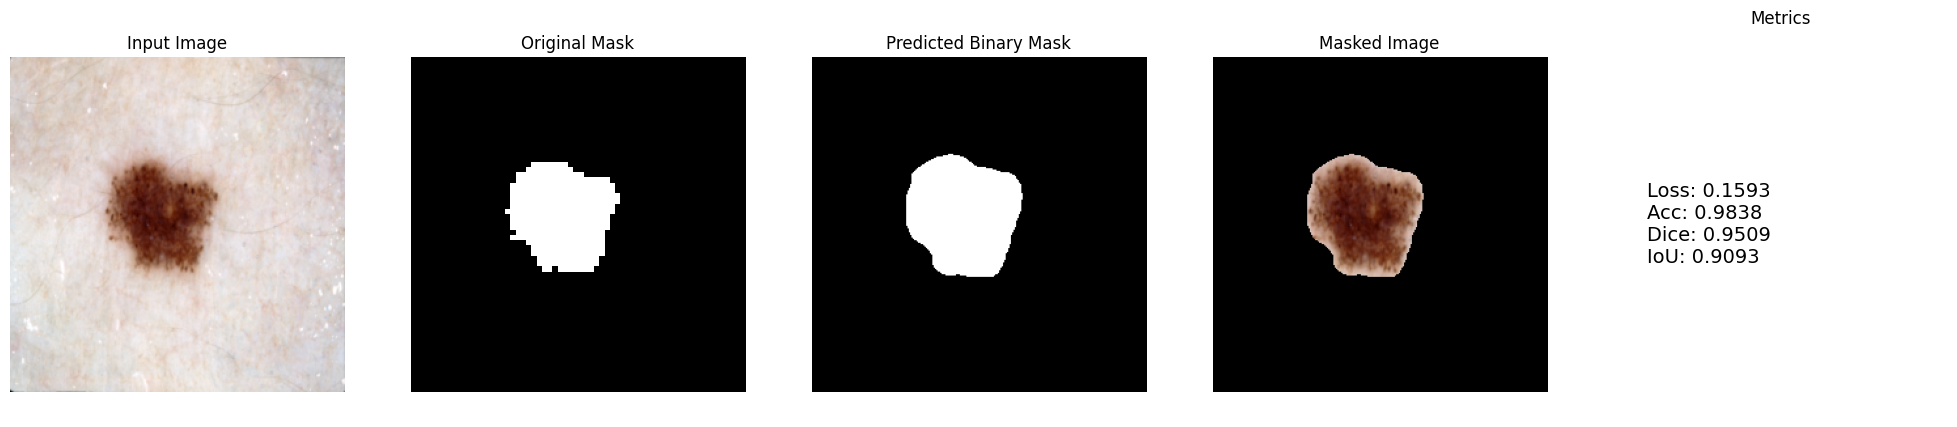


--- Testing on HAM 10000 dataset (Visualization) ---


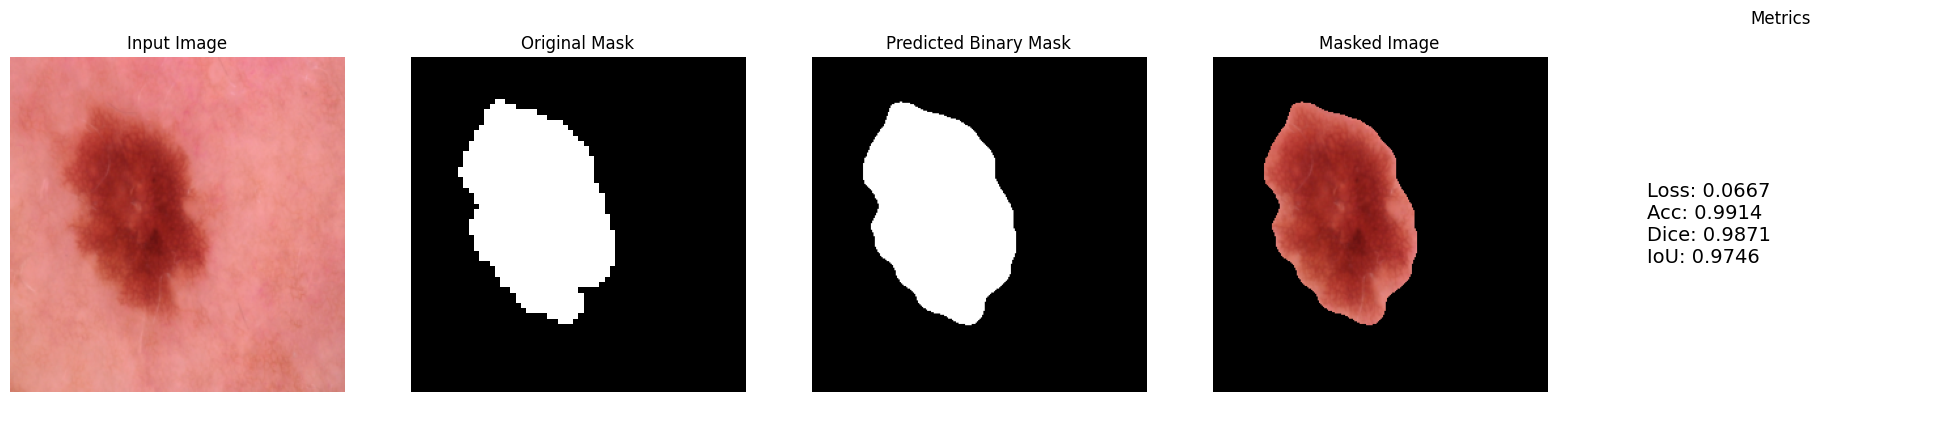

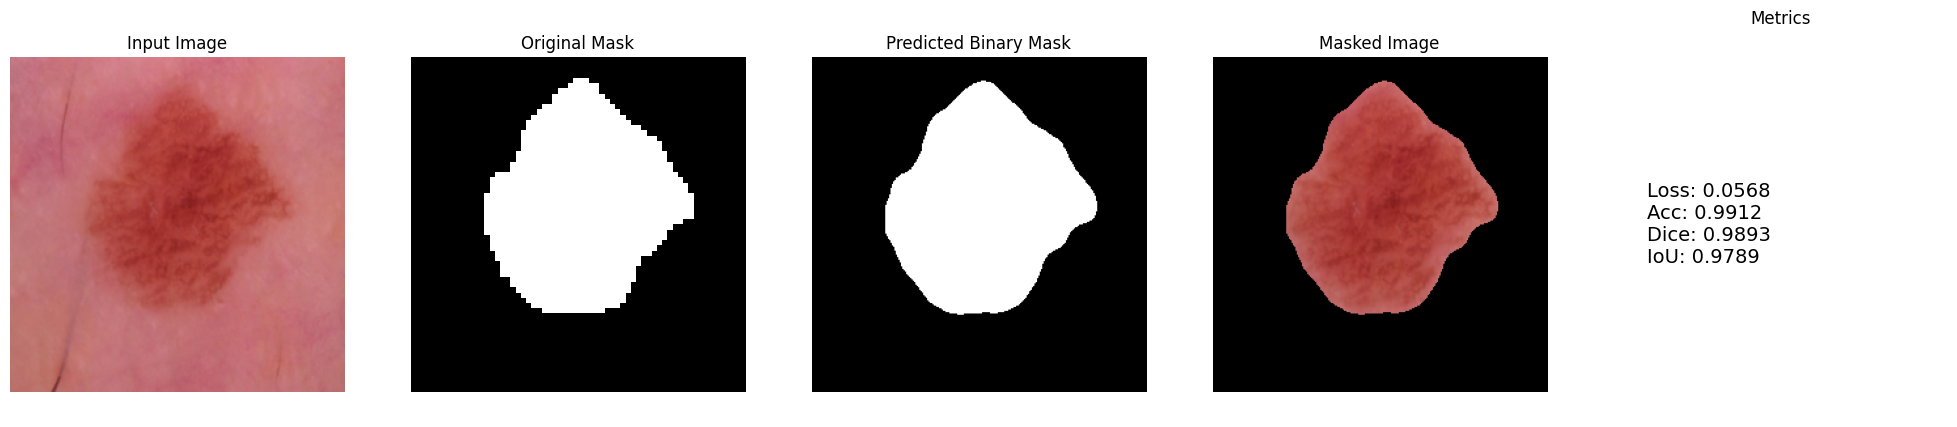

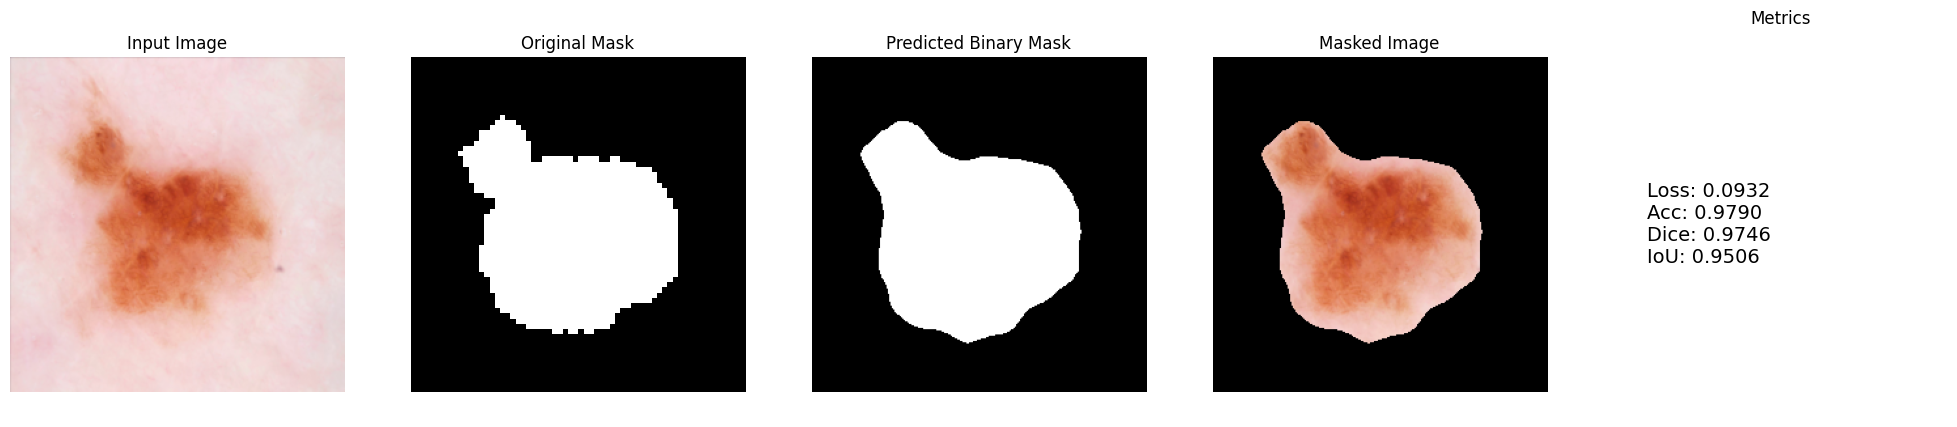


--- Evaluating Metrics on ISIC-2016 dataset ---


ISIC-2016 Final Metrics: Loss: 0.2150, Acc: 0.9548, Dice: 0.9269, IoU: 0.8775

--- Evaluating Metrics on ISIC-2018 dataset ---


Evaluating ISIC-2018:  86%|████████▌ | 171/200 [07:23<01:30,  3.13s/it, loss=0.3505, acc=0.9413, dice=0.8973, iou=0.8436]

In [ ]:
import os
import glob
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress display

# -------------------------------
# Step 1: Define a helper to get file paths
# -------------------------------
def get_file_paths(images_dir, masks_dir, extensions=('.jpg', '.png', '.jpeg'), num_samples=800):
    image_paths = []
    mask_paths = []
    for ext in extensions:
        image_paths.extend(glob.glob(os.path.join(images_dir, f"*{ext}")))
        mask_paths.extend(glob.glob(os.path.join(masks_dir, f"*{ext}")))
    image_paths = sorted(image_paths)
    mask_paths = sorted(mask_paths)
    total_samples = min(num_samples, len(image_paths), len(mask_paths))
    indices = random.sample(range(len(image_paths)), total_samples)
    sampled_image_paths = [image_paths[i] for i in indices]
    sampled_mask_paths = [mask_paths[i] for i in indices]
    return sampled_image_paths, sampled_mask_paths

# -------------------------------
# Step 2: Import SamProcessor and define preprocessing functions
# -------------------------------
try:
    from transformers import SamProcessor
except ImportError as e:
    raise ImportError("SamProcessor could not be imported. Ensure you have installed the transformers package: pip install transformers") from e

def get_bounding_box(ground_truth_map):
    if ground_truth_map.ndim > 2:
        ground_truth_map = np.squeeze(ground_truth_map)
    coords = np.column_stack(np.where(ground_truth_map > 0))
    if coords.size == 0:
        return None
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return [int(x_min), int(y_min), int(x_max), int(y_max)]

def preprocess_for_unet(image_tensor):
    return T.Resize((256, 256))(image_tensor)

class CombinedDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load original images and masks as PIL images.
        orig_image = Image.open(self.image_paths[idx]).convert("RGB")
        orig_mask  = Image.open(self.mask_paths[idx]).convert("L")
        
        # Apply augmentation if provided.
        if self.transform:
            image_tensor, mask_tensor = self.transform(orig_image, orig_mask)
        else:
            image_tensor = TF.to_tensor(orig_image)
            mask_tensor = TF.to_tensor(orig_mask)
        
        # For the SAM branch, use the original PIL image.
        gt_mask_np = np.array(orig_mask)
        bbox = get_bounding_box(gt_mask_np)
        if bbox is None:
            bbox = [0, 0, 0, 0]
        
        # Generate SAM inputs. Assumes the processor accepts a PIL image and input_boxes.
        inputs = self.processor(orig_image, input_boxes=[[bbox]], return_tensors="pt")
        sam_inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        # Note: ground_truth_mask may have a variable size.
        sam_inputs["ground_truth_mask"] = torch.tensor(gt_mask_np, dtype=torch.int64)
        
        # For the U-Net branch, resize the (augmented) image.
        unet_inputs = preprocess_for_unet(image_tensor)
        
        return sam_inputs, unet_inputs, mask_tensor

class SegmentationAugmentation:
    def __init__(self, resize=(1024, 1024), mask_size=(64, 64), augmentation=True, angle_range=(0, 0)):
        self.resize = resize
        self.mask_size = mask_size
        self.augmentation = augmentation
        self.angle_range = angle_range if augmentation else (0, 0)

    def __call__(self, image, mask):
        if self.augmentation:
            if random.random() < 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            angle = random.uniform(*self.angle_range)
            image = TF.rotate(image, angle, interpolation=T.InterpolationMode.BILINEAR, fill=0)
            mask = TF.rotate(mask, angle, interpolation=T.InterpolationMode.NEAREST, fill=0)
        image = TF.resize(image, self.resize, interpolation=T.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, self.mask_size, interpolation=T.InterpolationMode.NEAREST)
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

# -------------------------------
# Step 3: Define dataset paths and sample file paths
# -------------------------------
# ISIC-2016
isic2016_images_dir = "/kaggle/input/isic-segmentation-2016/ISIC 2016/test"
isic2016_masks_dir  = "/kaggle/input/isic-segmentation-2016/ISIC 2016/test_masks"
isic2016_image_paths, isic2016_mask_paths = get_file_paths(isic2016_images_dir, isic2016_masks_dir, num_samples=800)

# ISIC-2018
isic2018_images_dir = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input"
isic2018_masks_dir  = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth"
isic2018_image_paths, isic2018_mask_paths = get_file_paths(isic2018_images_dir, isic2018_masks_dir, num_samples=800)

# HAM 10000
ham_images_dir = "/kaggle/input/ham1000-segmentation-and-classification/images"
ham_masks_dir  = "/kaggle/input/ham1000-segmentation-and-classification/masks"
ham_image_paths, ham_mask_paths = get_file_paths(ham_images_dir, ham_masks_dir, num_samples=800)

# -------------------------------
# Step 4: Instantiate the processor and dataset objects
# -------------------------------
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
seg_augmentation = SegmentationAugmentation(resize=(1024, 1024), mask_size=(64, 64), augmentation=False)

isic2016_dataset = CombinedDataset(isic2016_image_paths, isic2016_mask_paths, processor, transform=seg_augmentation)
isic2018_dataset = CombinedDataset(isic2018_image_paths, isic2018_mask_paths, processor, transform=seg_augmentation)
ham_dataset     = CombinedDataset(ham_image_paths, ham_mask_paths, processor, transform=seg_augmentation)

# -------------------------------
# Step 5: Define a custom collate function to handle variable-size tensors.
# -------------------------------
def custom_collate_fn(batch):
    sam_inputs_list, unet_inputs_list, mask_tensor_list = zip(*batch)
    
    collated_sam_inputs = {}
    for key in sam_inputs_list[0].keys():
        shapes = [d[key].shape for d in sam_inputs_list]
        if all(shape == shapes[0] for shape in shapes):
            collated_sam_inputs[key] = torch.stack([d[key] for d in sam_inputs_list], dim=0)
        else:
            collated_sam_inputs[key] = [d[key] for d in sam_inputs_list]
    
    collated_unet_inputs = torch.stack(unet_inputs_list, dim=0)
    
    mask_shapes = [m.shape for m in mask_tensor_list]
    if all(shape == mask_shapes[0] for shape in mask_shapes):
        collated_mask_tensors = torch.stack(mask_tensor_list, dim=0)
    else:
        collated_mask_tensors = list(mask_tensor_list)
    
    return collated_sam_inputs, collated_unet_inputs, collated_mask_tensors


print("ISIC-2016 dataset length:", len(isic2016_dataset))
print("ISIC-2018 dataset length:", len(isic2018_dataset))
print("HAM 10000 dataset length:", len(ham_dataset))

# -------------------------------
# Step 6: Testing - Inference and Visualization on Random Samples
# -------------------------------

# Load the Best Model Checkpoint.
best_checkpoint = os.path.join(checkpoint_dir, "SEG_best_model.pth")
model.load_state_dict(torch.load(best_checkpoint))
model.eval()

# Prepare a dictionary mapping dataset names to dataset objects.
datasets_to_test = {
    "ISIC-2016": isic2016_dataset,
    "ISIC-2018": isic2018_dataset,
    "HAM 10000": ham_dataset
}

for dataset_name, dataset in datasets_to_test.items():
    print(f"\n--- Testing on {dataset_name} dataset (Visualization) ---")
    # Select 3 random samples.
    sample_indices = random.sample(range(len(dataset)), 3)
    for idx in sample_indices:
        sam_inputs, unet_inputs, mask = dataset[idx]

        # Prepare inputs: add batch dimension and send to device.
        sam_tensor = sam_inputs["pixel_values"].unsqueeze(0).to(device, memory_format=torch.channels_last)
        unet_tensor = unet_inputs.unsqueeze(0).to(device, memory_format=torch.channels_last)

        # Inference: Get model predictions.
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(sam_tensor, unet_tensor)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                # Apply sigmoid activation and threshold to obtain binary masks.
                #outputs = torch.sigmoid(outputs)
                pred_mask = (outputs > 0.5).float()

        # Resize the ground truth mask to the output size if needed.
        gt_mask_resized = torch.nn.functional.interpolate(mask.unsqueeze(0).to(device), 
                                                          size=outputs.shape[2:], 
                                                          mode='nearest')
        # Compute metrics for this sample.
        loss_val = criterion(outputs, gt_mask_resized)
        acc_val  = pixel_accuracy(outputs, gt_mask_resized)
        dice_val = compute_dice(outputs, gt_mask_resized)
        iou_val  = compute_iou(outputs, gt_mask_resized)

        # Prepare data for visualization.
        input_image = unet_inputs.cpu().numpy()
        if input_image.shape[0] in [1, 3]:
            input_image = input_image.transpose(1, 2, 0)
        
        original_mask = mask.cpu().numpy().squeeze()
        predicted_mask = pred_mask.squeeze().cpu().numpy()
        if input_image.ndim == 3 and input_image.shape[2] > 1:
            masked_image = input_image * predicted_mask[..., None]
        else:
            masked_image = input_image * predicted_mask

        # Create a figure with 5 subplots:
        # 1: Input image, 2: Original mask, 3: Predicted binary mask, 4: Masked image, 5: Metrics
        plt.figure(figsize=(25, 5))
        
        plt.subplot(1, 5, 1)
        plt.imshow(input_image.squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(1, 5, 2)
        plt.imshow(original_mask, cmap='gray')
        plt.title('Original Mask')
        plt.axis('off')
        
        plt.subplot(1, 5, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Binary Mask')
        plt.axis('off')
        
        plt.subplot(1, 5, 4)
        plt.imshow(masked_image.squeeze(), cmap='gray')
        plt.title('Masked Image')
        plt.axis('off')
        
        plt.subplot(1, 5, 5)
        metrics_text = (f"Loss: {loss_val.item():.4f}\n"
                        f"Acc: {acc_val:.4f}\n"
                        f"Dice: {dice_val:.4f}\n"
                        f"IoU: {iou_val:.4f}")
        plt.text(0.1, 0.5, metrics_text, fontsize=14, verticalalignment='center')
        plt.title('Metrics')
        plt.axis('off')
        
        plt.show()


# -------------------------------
# Step 7: Metrics Computation on Test Data
# -------------------------------
for dataset_name, dataset in datasets_to_test.items():
    print(f"\n--- Evaluating Metrics on {dataset_name} dataset ---")
    # Use a DataLoader without shuffling to process the entire dataset.
    loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)
    test_metrics = {'loss': 0.0, 'acc': 0.0, 'dice': 0.0, 'iou': 0.0}
    total_samples = 0

    val_loop = tqdm(loader, desc=f"Evaluating {dataset_name}", leave=False)
    for sam_inputs, unet_inputs, masks in val_loop:
        batch_size = unet_inputs.size(0)
        total_samples += batch_size

        # The tensors from the DataLoader are already batched (rank 4),
        # so we remove unsqueeze(0) to avoid increasing the rank.
        sam_tensor = sam_inputs["pixel_values"].to(device, memory_format=torch.channels_last)
        unet_tensor = unet_inputs.to(device, memory_format=torch.channels_last)
        # If masks is a list (due to variable sizes), stack them.
        if isinstance(masks, list):
            masks = torch.stack(masks, dim=0)
        masks = masks.to(device)

        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(sam_tensor, unet_tensor)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                # Apply sigmoid activation and threshold to obtain binary masks.
                #outputs = torch.sigmoid(outputs)
                pred_mask = (outputs > 0.5).float()

        # Compute loss using the probability outputs.
        loss = criterion(outputs, masks)
        test_metrics['loss'] += loss.item() * batch_size
        # Compute accuracy, Dice, and IoU using the binary prediction.
        test_metrics['acc']  += pixel_accuracy(pred_mask, masks) * batch_size
        test_metrics['dice'] += compute_dice(pred_mask, masks) * batch_size
        test_metrics['iou']  += compute_iou(pred_mask, masks) * batch_size

        avg_loss = test_metrics['loss'] / total_samples
        avg_acc  = test_metrics['acc']  / total_samples
        avg_dice = test_metrics['dice'] / total_samples
        avg_iou  = test_metrics['iou']  / total_samples
        val_loop.set_postfix({
            'loss': f"{avg_loss:.4f}",
            'acc': f"{avg_acc:.4f}",
            'dice': f"{avg_dice:.4f}",
            'iou': f"{avg_iou:.4f}"
        })

    final_loss = test_metrics['loss'] / total_samples
    final_acc  = test_metrics['acc']  / total_samples
    final_dice = test_metrics['dice'] / total_samples
    final_iou  = test_metrics['iou']  / total_samples

    print(f"{dataset_name} Final Metrics: Loss: {final_loss:.4f}, Acc: {final_acc:.4f}, Dice: {final_dice:.4f}, IoU: {final_iou:.4f}")
